In [1]:
import anndata as ad
import anndata2ri
import logging
import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(Seurat)
library(sctransform)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### Adjustment to SCTransform

https://doi.org/10.1186/s13059-021-02451-7 suggests that calculating $\theta$ for each gene overspecifies SCTransform despite the kernel regression for scRNA.

Given that scATAC data has about 10x more "genes" (or in this case sequences of the DNA) we have to fit 10x more negative binomial regressions. Adding to that the much smaller range of fragment counts and the much lower mean and variance of the fragment counts in the data, overfitting may be a bigger problem in scATAC data than in scRNA.

That being said, while the source above argued for the method we adapted in this notebook, it is important to mention that the overdispersion seems to be much stronger in scATAC data than in scRNA data, which would make the parameter more important.

If time permits, we'll investigate this further:

- in scRNA sequencing, there are linear trends in the smoothed estimates in the original SCTransform paper method, do these persist in scATAC data?
- is there a biologically meaningful relationship between the expression strength and the overdispersion parameter?
- simulate data with constant $\theta$ and see if $\theta$ estimates still increase with average UMI count.
- One of the main arguments in the paper above was that the overdispersion was low and thus the exact value of $\theta$ does only weakly affect the variance. While we have much more overdispersion, we also have much lower average UMI counts and thus the actual growth in variance compared to the mean is very low, since overdispersion grows quadratic in the mean

In [3]:
adata = sc.read("/mnt/storage/adata_normalized.h5ad")

In [4]:
adata.X = adata.layers["raw_fragments"]

In [5]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv["adata"] = adata

In [6]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res = SCTransform(object=seurat_obj, method = "offset_shared_theta_estimate", theta_given = 0.1, return.only.var.genes = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%


In [7]:
norm_x = ro.r("res@assays$SCT@scale.data").T
adata.layers["scTransform_normalization_c1"] = norm_x

Text(0.5, 1.0, 'Distribution of Residuals')

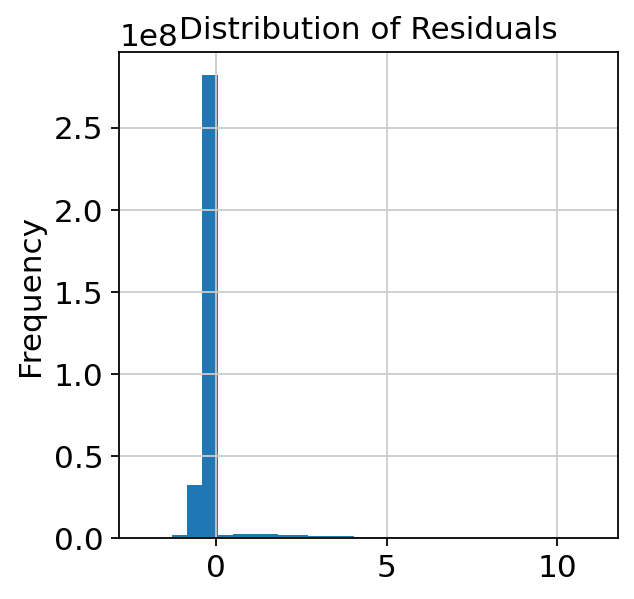

In [8]:
X_res = adata.layers["scTransform_normalization"]
plt.hist(X_res.flatten(), bins = 30)
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

  |======================================================================| 100%
  |======================================================================| 100%


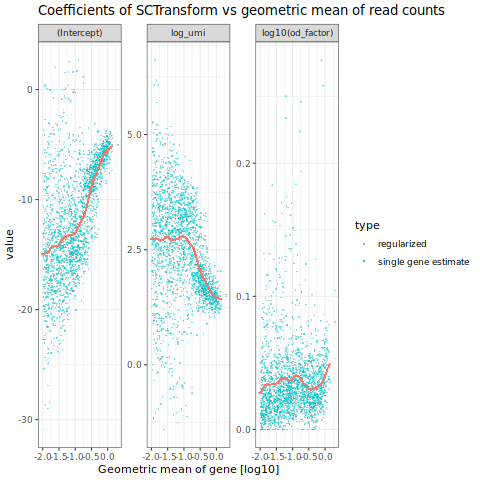

: 

In [27]:
%%R
vst_out = vst(seurat_obj@assays$RNA@counts, method = "glmGamPoi")
library(ggplot2)

plot <- plot_model_pars(
  vst_out,
  xaxis = "gmean",
  show_theta = FALSE,
  show_var = FALSE,
  verbosity = 2,
  verbose = NULL,
  show_progress = NULL
)
plot + theme_bw() + ggtitle("Coefficients of SCTransform vs geometric mean of read counts")

In [ ]:
adata.write("/mnt/storage/adata_normalized_custom.h5ad")